In [1]:
%load_ext autoreload
%autoreload 2
from lib.preamble import *

%matplotlib widget
import warnings

data = []

In [2]:
# import backgrounds
paths = glob("../data/2023-12-05*/d*.asc")
paths += glob("../data/2023-12-06*/d*.asc")
paths += glob("../data/2023-12-07*/d*.asc")
paths += glob("../data/2023-12-12*/d*.asc")
paths += glob("../data/2023-12-13*/d*.asc")
paths += glob("../data/2023-12-14*/d*.asc")
paths += glob("../data/2023-12-19*/d*.asc")
paths += glob("../data/2023-12-20*/d*.asc")
paths += glob("../data/2023-12-21*/d*.asc")
paths += glob("../data/2023-12-22*/d*.asc")
paths += glob("../data/2024-01-09*/d*.asc")
paths = [p for p in paths if "bkg" in p]
paths.sort()

import csv

def _read_csv(path):
	rows = []
	with open(path) as f:
		r = csv.reader(f, delimiter="\t")
		for row in r:
			if len(row) == 0:
				return rows
			rows.append(row)
	return rows

def custom_import_spectra(p):
	d = np.array(_read_csv(p))[:, :-1]
	# convert strings to floats
	d = d.astype(float)

	ar = xr.DataArray(
		d[:, 1],
		coords={
			'wavelength': d[:, 0]
		}
	)

	# get the metadata
	number, exposure = p.replace(".", "_").split("s")[0].split("_")[-1].split("x")

	ar.attrs = {
		**ar.attrs,
		"path": p.split("data/")[-1],
		"name": p.split("data/")[-1].split(".")[0],
		"number": int(number),
		"exposure": float(exposure),
	}
	ar.name = ar.attrs["name"]
	
	return ar

bkg = [custom_import_spectra(p) for p in paths]
bkg_new = bkg.copy()

bkg[0] = bkg[0] / 3
bkg[1] = bkg[1] / 3
bkg[2] = bkg[2] / 5

import difflib

def background_substract_old(sel, b=None):
	if b is np.nan:
		return None
	if b is None:		
		same_folder = [b for b in bkg if sel.name.split("/")[0] in b.name]
		if len(same_folder) == 1: b=same_folder[0]
		elif len(same_folder) > 1:
			b_name = difflib.get_close_matches(sel, [b.name for b in same_folder], n=1, cutoff=0)[0]
			b = [b for b in same_folder if b.name == b_name][0]
		else:
			before = [b for b in bkg if b.name < sel.name]
			if before:
				b = sorted(before, key=lambda x: x.name)[-1]
			else:
				b = sorted(bkg, key=lambda x: x.name)[0]
	
	d =  sel - b.interp(wavelength=sel.wavelength, kwargs={"fill_value": np.nan})
	d.attrs = sel.attrs
	d.name = sel.name
	d.attrs["background"] = b

	d = d.dropna("wavelength")

	d /= d.attrs["number"]
	d /= d.attrs["exposure"]

	return d


bkg = bkg_new

# create a script that
def background_substract(sel, b=None):
	if b is not None:
		return background_substract_old(sel, b)
	
	exposure = sel.attrs["exposure"]
	wavelength = (sel.wavelength.min(), sel.wavelength.max())

	# get all backgrounds with the same exposure
	same_exposure = [b for b in bkg if b.attrs["exposure"] == exposure]

	# find the same wavelength
	same_wavelength = [b for b in same_exposure if b.wavelength.min() <= wavelength[0] and b.wavelength.max() >= wavelength[1]]

	# if there is only one, use it
	if len(same_wavelength) == 1: b=same_wavelength[0]

	# if there are more, use the one with the closest wavelength
	elif len(same_wavelength) > 1:
		b_name = difflib.get_close_matches(sel, [b.name for b in same_wavelength], n=1, cutoff=0)[0]
		b = [b for b in same_wavelength if b.name == b_name][0]
	
	else:
		# check if there is a partial match of the wavelength
		partial_match = [b for b in same_exposure if b.wavelength.min() <= wavelength[0] or b.wavelength.max() >= wavelength[1]]
		if len(partial_match) == 1: b=partial_match[0]
		
		# take the closest one
		elif len(partial_match) > 1:
			# b_name = difflib.get_close_matches(sel, [b.name for b in partial_match], n=1, cutoff=0)[0]
			# b = [b for b in partial_match if b.name == b_name][0]
			b = sorted(partial_match, key=lambda x: np.abs(x.wavelength.mean() - sel.wavelength.mean()))[0]
		
		else:
			warnings.warn(f"no background found for {sel.name}")
			return sel
	
	return background_substract_old(sel, 
		b * sel.attrs["number"] / b.attrs["number"]
	)


pprint([b.name for b in bkg])

# import all from 2023-12-06 and 07 done with custom script
import h5py

paths = glob("../data/2023-12-05*/*hd5.h5")
paths += glob("../data/2023-12-06*/*.h5")
paths += glob("../data/2023-12-07*/*.h5")
paths += glob("../data/2023-12-08*/*.h5")
paths += glob("../data/2023-12-11*/*.h5")
paths += glob("../data/2023-12-12*/*.h5")
paths += glob("../data/2023-12-13*/*.h5")
paths += glob("../data/2023-12-14*/*.h5")
paths += glob("../data/2023-12-15*/*.h5")
paths += glob("../data/2023-12-18*/*.h5")
paths += glob("../data/2023-12-19*/*.h5")
paths += glob("../data/2023-12-20*/*.h5")
paths += glob("../data/2023-12-21*/*.h5")
paths += glob("../data/2023-12-22*/*.h5")
paths += glob("../data/2024-01-09*/*.h5")
paths += glob("../data/2024-02-14*/*.h5")
paths += glob("../data/2024-02-15*/*.h5")
paths += glob("../data/2024-02-16*/*.h5")
paths.sort()

# paths = list(filter(lambda p: "hd5" not in p, paths))

def import_custom_script(p):
	with h5py.File(p, "r") as f:
		angle_count = len(np.unique(f['apt_angle']))

		if "magnet_field" in f:
			field = f["magnet_field"][::angle_count]
		else:
			field = np.array([np.nan])

		angle = f["apt_angle"][:angle_count]
		wavelength = f["wavelength"][0]
		counts = f["counts"][:].reshape(field.shape[0], angle.shape[0], wavelength.shape[0])

		time = f["time"][:].reshape(field.shape[0], angle.shape[0])

		if "temperature" in f:
			temperature = f["temperature"][:].reshape(field.shape[0], angle.shape[0])
		else:
			temperature = np.full_like(time, np.nan)

		if "position" in f:
			position = f["position"][:].reshape(field.shape[0], angle.shape[0], 3)
		else:
			position = np.full_like(counts, np.nan)

		exposure = f["data_full"]["spectrometer"]["exposure"][0]
		number = f["data_full"]["spectrometer"]["number"][0]

	ar = xr.DataArray(
		counts,
		dims=["field", "angle", "wavelength"],
		coords={
			"field": field,
			"angle": angle,
			"wavelength": wavelength,
		},
		attrs={
			"exposure": exposure,
			"number": number,
		}
	)

	# add coord time
	ar.coords["time"] = (
		["field", "angle"],
		time
	)

	# add coord temperature
	ar.coords["temperature"] = (
		["field", "angle"],
		temperature
	)

	return ar

def import_files(p):

	try:
		ar = import_custom_script(p)
	except:
		print(f"Error importing:\t{p}")
		return None

	# if ar is None:
		# return None
	
	ar.attrs = {
		**ar.attrs,
		"path": p.split("data/")[-1],
		"name": ".".join(p.split("data/")[-1].split(".")[:-1]),
	}
	ar.name = ar.attrs["name"]


	diff_field = np.diff(ar.field)
	if np.all(diff_field > 0):
		ar.attrs["field_direction"] = 1.
	elif np.all(diff_field < 0):
		ar.attrs["field_direction"] = -1.
	else:
		ar.attrs["field_direction"] = np.nan

	return ar

data_import = [import_files(p) for p in paths]
data_import = [d for d in data_import if d is not None]
data_import = [background_substract(d) for d in data_import]
data = [d for d in data if d.name not in [d.name for d in data_import]]
data += data_import

# add energy coordinates
data = [d.assign_coords(energy=1239.84193/d.wavelength) for d in data]

['2023-12-05_LO_MG_NiPS3/d001_bkg_15x5s',
 '2023-12-07_LO_MG_NiPS3/d003_bkg_15x5s',
 '2023-12-13_CrPS4_outPlane/d001_bkg_25x5s_horPol',
 '2023-12-14_CrPS4_outPlane/d002_bkg_25x3s',
 '2023-12-14_CrPS4_outPlane/d008_bkg_25x10s',
 '2023-12-20_NiPS3_inPlane/d002_bkg_10x10s',
 '2023-12-20_NiPS3_inPlane/d005_bkg_25x5s_smaller_slit',
 '2023-12-21_NiPS3_inPlane/d001_bkg_10x10s',
 '2023-12-22_NiPS3_inPlane/d001_bkg_5x5s',
 '2024-01-09_NiPS3_inPlane/d002_bkg_5x10s']
Error importing:	../data/2023-12-05_LO_MG_NiPS3/d004_10K_647nm_rotPolDet_26degPolExc_flake04.hd5.h5
Error importing:	../data/2023-12-06_LO_MG_NiPS3/d001_50K_647nm_rotPolDet_flake04_sweepUp_inPlane.hd5.h5
Error importing:	../data/2023-12-06_LO_MG_NiPS3/d002_10K_647nm_rotPolDet_flake04_sweepDown_inPlane.hd5.h5
Error importing:	../data/2023-12-06_LO_MG_NiPS3/d003_pol_10K_flake05.hd5.h5
Error importing:	../data/2023-12-06_LO_MG_NiPS3/d004_10K_647nm_rotPolDet_flake05_sweepDown_inPlane.hd5.h5
Error importing:	../data/2024-02-15 CrPS4 outPl

/tmp/ipykernel_328557/4197825817.py:128: UserWarning: no background found for 2024-02-14 CrPS4 outPlane linPolExc linPolDet/d001_280K.hd5_6
  warnings.warn(f"no background found for {sel.name}")
/tmp/ipykernel_328557/4197825817.py:128: UserWarning: no background found for 2024-02-14 CrPS4 outPlane linPolExc linPolDet/d002_100K.hd5_4
  warnings.warn(f"no background found for {sel.name}")
/tmp/ipykernel_328557/4197825817.py:128: UserWarning: no background found for 2024-02-15 CrPS4 outPlane linPolExc linPolDet/d001_70K.hd5_5
  warnings.warn(f"no background found for {sel.name}")
/tmp/ipykernel_328557/4197825817.py:128: UserWarning: no background found for 2024-02-15 CrPS4 outPlane linPolExc linPolDet/d002_45K.hd5_1
  warnings.warn(f"no background found for {sel.name}")
/tmp/ipykernel_328557/4197825817.py:128: UserWarning: no background found for 2024-02-15 CrPS4 outPlane linPolExc linPolDet/d003_5K.hd5_1
  warnings.warn(f"no background found for {sel.name}")
/tmp/ipykernel_328557/4197825

# CrPS4

{0: '2023-12-13_CrPS4_outPlane/d007_circPolDet_linExcPol_50K_3x3s_flake03',
 1: '2023-12-14_CrPS4_outPlane/d009_circPolDet_linExcPol_10K_flake03_4mW',
 2: '2023-12-15_CrPS4_inPlane/d002_circPolDet_linExcPol_10K_flake03_4mW'}


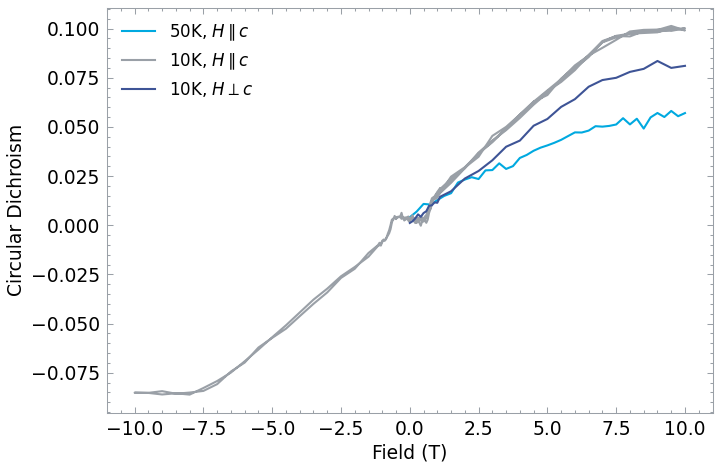

In [3]:
def pre(sel):
	ret = dichroism(
		sel.mean("wavelength")
	)
	# ret = ret - ret.drop_duplicates("field").sel(field=0)
	return ret

sel_mult = [d for d in data if "CrPS4" in d.name and "circPolDet" in d.name and 0. in d.field]
sel_mult = sel_mult[:1] + sel_mult[3:]

pprint({i:d.name for i,d in enumerate(sel_mult)})

plt.figure()
for sel in sel_mult:
    sel = pre(sel)
    # sel = sel.rolling(field=2).mean()
    # sel = sel.diff("field")
    sel.plot(_labels=False,
             label = sel.name.split("K_")[0].split("_")[-1] + "K, "\
			# + f'flake {int(sel.name.split("flake")[-1].split("_")[0])}, '\
			# + "sweep:" + (
			# 	r"$\rightarrow$" if sel.field_direction>0 else (
			# 		r"$\leftarrow$" if sel.field_direction<0 else r"$\leftrightarrow$"
			# 	))
			+ (
				r"$H\parallel c$" if "out" in sel.name else r"$H\perp c$"
			)
    )
plt.legend(fontsize=FONTSIZE_TINY)
plt.xlabel("Field (T)")
plt.ylabel("Circular Dichroism")
plt.show()

['2023-12-13_CrPS4_outPlane/d007_circPolDet_linExcPol_50K_3x3s_flake03',
 '2023-12-14_CrPS4_outPlane/d009_circPolDet_linExcPol_10K_flake03_4mW',
 '2023-12-15_CrPS4_inPlane/d002_circPolDet_linExcPol_10K_flake03_4mW']
residual CD:  0.0027131452177084833


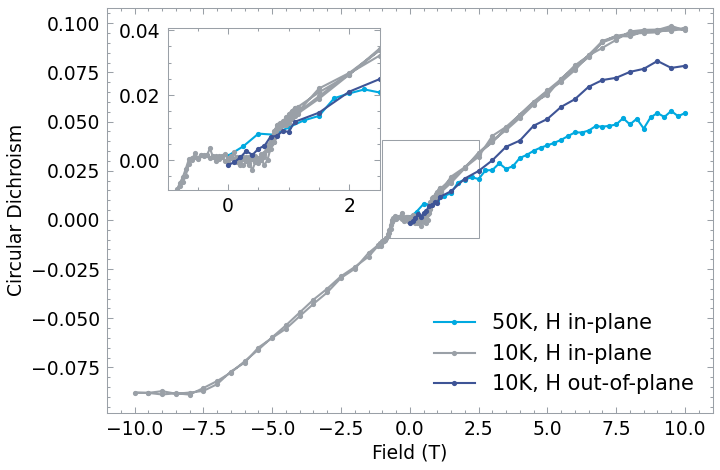

In [4]:
wavelength_slice = slice(910,915)

sel_mult = [d for d in data if "CrPS4" in d.name and "circPolDet" in d.name and 0. in d.field]
sel_mult = sel_mult[:1] + sel_mult[3:]


pprint([d.name for d in sel_mult])



def pre(sel):
	ret = dichroism(
		sel.mean("wavelength")
	)
	# ret = ret - ret.drop_duplicates("field").sel(field=0)
	return ret

# define a 0 CD to absorb imprecisions in the setup
zero = np.mean([pre(d).sel(field=0).mean() for d in sel_mult])

print("residual CD: ", zero)

plt.figure()

ax = plt.subplot()
axi = ax.inset_axes([0.1, 0.55, 0.35, 0.4])


for sel in sel_mult:
	for a in [ax, axi]:
		d = (pre(sel)-zero)
		# d = d.rolling(field=2, center=True).mean()
		d.plot(
			ax=a,
			marker=".",
			# label=sel.name,
			label = sel.name.split("K_")[0].split("_")[-1] + "K, "\
			# + f'flake {int(sel.name.split("flake")[-1].split("_")[0])}, '\
			# + "sweep:" + (
			# 	r"$\rightarrow$" if sel.field_direction>0 else (
			# 		r"$\leftarrow$" if sel.field_direction<0 else r"$\leftrightarrow$"
			# 	)
			# ) + ", " 
			+ (
				# r"$H\parallel c$" if "out" in sel.name else r"$H\perp c$
				"H in-plane" if "out" in sel.name else "H out-of-plane"
			)
			,

		)

ax.set_ylabel("Circular Dichroism")
axi.set_ylabel("")
axi.set_xlabel("")

# set axi xlimits to -1,1 and ylimits automatically
field_slice = slice(-1, 2.5)
cd_boundary = (
	np.min([pre(d).sortby("field").sel(field=field_slice).min() for d in sel_mult])*1.1,
	np.max([pre(d).sortby("field").sel(field=field_slice).max() for d in sel_mult])*1.1
)
axi.set_xlim(field_slice.start, field_slice.stop)
axi.set_ylim(*cd_boundary)

# draw a rectangle
ax.add_patch(
	mpl.patches.Rectangle(
		(field_slice.start, cd_boundary[0]),
		field_slice.stop - field_slice.start,
		cd_boundary[1] - cd_boundary[0],
		linewidth=.5, edgecolor=SEEGRAU, facecolor='none'
	)
)

# for a in [ax, axi]: a.axvline(.68, linewidth=1, zorder=-1)
# plt.axvline(7.5, linewidth=1, zorder=-1)
# sec_ax = plt.gca().secondary_xaxis('top', functions=(lambda x: x, lambda x: x))
# sec_ax.set_ticks(
# 	[.68, 7.5], ["Spin-flop (10K)", "Spin-flip (10K)"]
# )

ax.set_xlabel("Field (T)")

ax.legend(loc="lower right")
plt.savefig("../figures/2023-12-14 circular dichroism measurement.png")
plt.savefig("../report/figures/2023-12-14 CrPS4 circular dichroism.pdf")
plt.show()

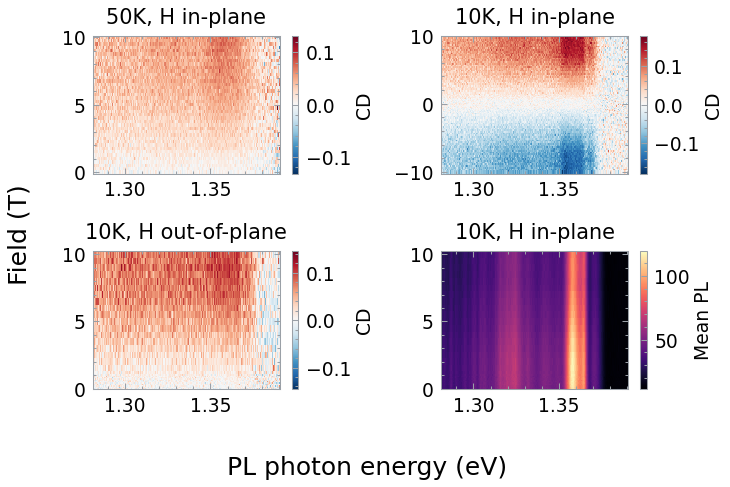

In [5]:
sel_mult = [d for d in data if "CrPS4" in d.name and "circPolDet" in d.name and 0. in d.field]
sel_mult = sel_mult[:1] + sel_mult[3:]

fig, axs = plt.subplots(2, 2)

for sel, ax in zip(sel_mult, axs.flatten()):
    sel = dichroism(sel.sortby("field"))
    sel = sel-zero
    img = sel.plot(ax=ax,add_labels=False, rasterized=True,
        y="field", x="energy", add_colorbar=False
    )
    plt.colorbar(img, label="CD")
    ax.set_title(sel.name.split("K_")[0].split("_")[-1] + "K, "\
			# + f'flake {int(sel.name.split("flake")[-1].split("_")[0])}, '\
			# + "sweep:" + (
			# 	r"$\rightarrow$" if sel.field_direction>0 else (
			# 		r"$\leftarrow$" if sel.field_direction<0 else r"$\leftrightarrow$"
			# 	))
			+ (
				"H in-plane" if "out" in sel.name else "H out-of-plane"
            )
    )

img = sel_mult[-1].mean("angle").plot(
    y="field", x="energy",
    ax=axs[-1, -1],
    rasterized=True,
    cmap=CMAP,
    add_labels=False,
    add_colorbar=False
)
plt.colorbar(img, label="Mean PL")
axs[-1,-1].set_title("10K, H in-plane")

fig.supxlabel("PL photon energy (eV)")
fig.supylabel("Field (T)")

# plt.savefig("../report/figures/2024-04-18 CrPS4 CD structure.pdf")
plt.show()


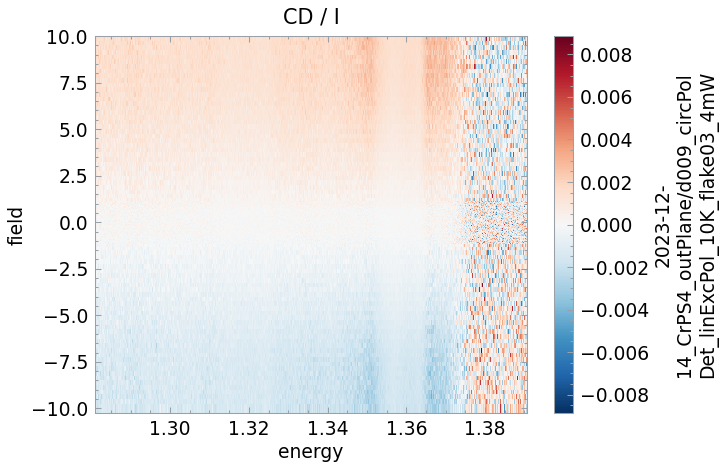

In [14]:
sel = sel_mult[1].sortby("field")

plt.figure()
(dichroism(sel)/sel.mean("angle")).plot(x="energy", y="field")
plt.title("CD / I")
plt.show()

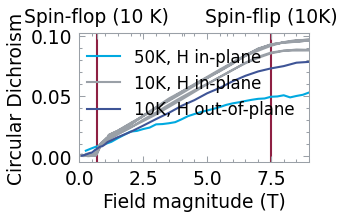

In [67]:
fig = plt.figure(figsize=FIGSIZE_SMALL)

def pre(sel):
	ret = dichroism(
		sel.mean("wavelength")
	)
	ret = ret - zero
	# ret = ret - ret.drop_duplicates("field").sel(field=0)
	return ret

sel_mult = [d for d in data if "CrPS4" in d.name and "circPolDet" in d.name and 0. in d.field]
sel_mult = sel_mult[:1] + sel_mult[3:]

for sel in sel_mult:
	sel = pre(sel)
	# sel = sel.diff("field")
	sel = sel.rolling(field=3, center=True).mean()
	sel = np.abs(sel)
	sel["field"] = np.abs(sel.field)
	sel.plot(_labels=False,
			 label = sel.name.split("K_")[0].split("_")[-1] + "K, "\
			# + f'flake {int(sel.name.split("flake")[-1].split("_")[0])}, '\
			# + "sweep:" + (
			# 	r"$\rightarrow$" if sel.field_direction>0 else (
			# 		r"$\leftarrow$" if sel.field_direction<0 else r"$\leftrightarrow$"
			# 	))
			+ (
				# r"$H\parallel c$" if "out" in sel.name else r"$H\perp c$"
				"H in-plane" if "out" in sel.name else "H out-of-plane"
			)
	)
plt.axvline(.68, linewidth=1, zorder=-1, color="C3")
plt.axvline(7.5, linewidth=1, zorder=-1, color="C3")
plt.xlim(0, 9)
sec_ax = plt.gca().secondary_xaxis('top', functions=(lambda x: x, lambda x: x))
sec_ax.set_ticks(
	[.68, 7.5], ["Spin-flop (10 K)", "Spin-flip (10K)"]
)

plt.legend(fontsize=FONTSIZE_TINY)
plt.xlabel("Field magnitude (T)")
plt.ylabel("Circular Dichroism")
plt.savefig("../report/figures/2024-04-10 circular dichroism measurement magnitude.pdf")
plt.show()

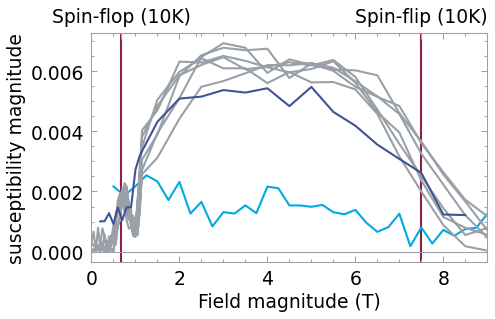

In [15]:
plt.figure(figsize=FIGSIZE_MEDIUM)

sel_mult = [d for d in data if "CrPS4" in d.name and "circPolDet" in d.name and 0. in d.field]
sel_mult = sel_mult[:1] + sel_mult[3:]

for sel in sel_mult:
	sel = pre(sel)
	sel = sel.diff("field")
	sel = sel.rolling(field=5, center=True).mean()
	sel = np.abs(sel)
	sel["field"] = np.abs(sel.field)
	sel.plot(_labels=False,
			 label = sel.name.split("K_")[0].split("_")[-1] + "K, "\
			# + f'flake {int(sel.name.split("flake")[-1].split("_")[0])}, '\
			# + "sweep:" + (
			# 	r"$\rightarrow$" if sel.field_direction>0 else (
			# 		r"$\leftarrow$" if sel.field_direction<0 else r"$\leftrightarrow$"
			# 	))
			+ (
				# r"$H\parallel c$" if "out" in sel.name else r"$H\perp c$"
				"H in-plane" if "out" in sel.name else "H out-of-plane"
			)
	)
plt.axhline(0, color=SEEGRAU, linewidth=0.5)
plt.axvline(.68, linewidth=1, zorder=-1, color="C3")
plt.axvline(7.5, linewidth=1, zorder=-1, color="C3")
sec_ax = plt.gca().secondary_xaxis('top', functions=(lambda x: x, lambda x: x))
sec_ax.set_ticks(
	[.68, 7.5], ["Spin-flop (10K)", "Spin-flip (10K)"]
)


plt.xlim(0, 9)

# plt.legend(fontsize=FONTSIZE_TINY, loc="upper right", frameon=True)
plt.xlabel("Field magnitude (T)")
plt.ylabel("susceptibility magnitude")
plt.savefig("../report/figures/2024-04-10 susceptibility dichroism measurement.pdf")
plt.show()

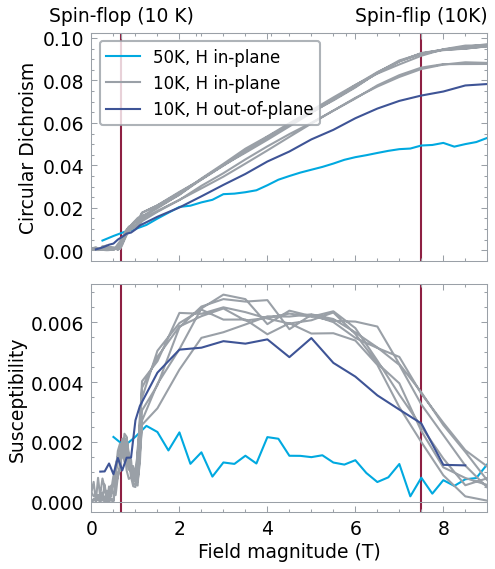

In [58]:
fig = plt.figure(figsize=(3.5, 4))

def pre(sel):
	ret = dichroism(
		sel.mean("wavelength")
	)
	ret = ret - zero
	# ret = ret - ret.drop_duplicates("field").sel(field=0)
	return ret

sel_mult = [d for d in data if "CrPS4" in d.name and "circPolDet" in d.name and 0. in d.field]
sel_mult = sel_mult[:1] + sel_mult[3:]


plt.subplot(2, 1, 1)
for sel in sel_mult:
	sel = pre(sel)
	# sel = sel.diff("field")
	sel = sel.rolling(field=3, center=True).mean()
	sel = np.abs(sel)
	sel["field"] = np.abs(sel.field)
	sel.plot(_labels=False,
			 label = sel.name.split("K_")[0].split("_")[-1] + "K, "\
			# + f'flake {int(sel.name.split("flake")[-1].split("_")[0])}, '\
			# + "sweep:" + (
			# 	r"$\rightarrow$" if sel.field_direction>0 else (
			# 		r"$\leftarrow$" if sel.field_direction<0 else r"$\leftrightarrow$"
			# 	))
			+ (
				# r"$H\parallel c$" if "out" in sel.name else r"$H\perp c$"
				"H in-plane" if "out" in sel.name else "H out-of-plane"
			)
	)
plt.axvline(.68, linewidth=1, zorder=-1, color="C3")
plt.axvline(7.5, linewidth=1, zorder=-1, color="C3")
plt.xlim(0, 9)
sec_ax = plt.gca().secondary_xaxis('top', functions=(lambda x: x, lambda x: x))
sec_ax.set_ticks(
	[.68, 7.5], ["Spin-flop (10 K)", "Spin-flip (10K)"]
)

plt.legend(fontsize=FONTSIZE_TINY, loc="upper left", frameon=True)
# plt.xlabel("Field magnitude (T)")
plt.ylabel("Circular Dichroism")

plot.hide_inner_label()


plt.subplot(2, 1, 2)
for sel in sel_mult:
	sel = pre(sel)
	sel = sel.diff("field")
	sel = sel.rolling(field=5, center=True).mean()
	sel = np.abs(sel)
	sel["field"] = np.abs(sel.field)
	sel.plot(_labels=False,
			 label = sel.name.split("K_")[0].split("_")[-1] + "K, "\
			# + f'flake {int(sel.name.split("flake")[-1].split("_")[0])}, '\
			# + "sweep:" + (
			# 	r"$\rightarrow$" if sel.field_direction>0 else (
			# 		r"$\leftarrow$" if sel.field_direction<0 else r"$\leftrightarrow$"
			# 	))
			+ (
				r"$H\parallel c$" if "out" in sel.name else r"$H\perp c$"
			)
	)
plt.axhline(0, color=SEEGRAU, linewidth=0.5)
plt.axvline(.68, linewidth=1, zorder=-1, color="C3")
plt.axvline(7.5, linewidth=1, zorder=-1, color="C3")


plt.xlim(0, 9)

# plt.legend(fontsize=FONTSIZE_TINY)
plt.xlabel("Field magnitude (T)")
plt.ylabel("Susceptibility")


plt.savefig("../report/figures/2024-04-10 combined.pdf")
plt.show()